In [266]:
import math
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import re
import seaborn as sns
import pandas as pd
import random
from scipy import stats  #t-test
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.interpolate import interp1d
from itertools import groupby
import glob
from scipy.signal import medfilt
from fastdtw import fastdtw
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip3 install fastdtw

In [3]:
def newfolder(pathin):
    folder = os.path.exists(pathin)
    if not folder:
        os.makedirs(pathin)

In [4]:
pathsave='/Volumes/jiarui/hanako/plot_test_sine' #path to save figures
if os.path.exists(pathsave)==False:
    newfolder(pathsave)

In [500]:
# Time base

t = np.linspace(0, 10, 1000)
t_shifted = t + 0.5  # Time shift
# Base sine wave
sync_base = np.sin(2 * np.pi * 1.0 * t)

# Add small noise to simulate natural variation
sig1_sync = sync_base + 0.01 * np.random.randn(len(t))
sig2_sync = 0.7*sync_base + 0.01 * np.random.randn(len(t))
# Base sine wave
async_base = np.sin(2 * np.pi * 1.0 * t)
async_base2 = np.sin(2 * np.pi * 1.0 * t_shifted)
# Signal 1: Original base with noise
sig1_async = async_base + 0.01 * np.random.randn(len(t))
sig2_async = async_base2 + 0.01 * np.random.randn(len(t_shifted))
sig1_async[100:150] =  0
sig1_async[250:300] =  0
sig1_async[400:450] =  0
#sig1_async[500:550] =  0
#sig1_async[700:750] =  0
#sig1_async[850:900] =  0

# Signal 2:
# - Delayed (rolled forward by 200 samples)
# - Second half lifted above baseline
# - Aligned with a shifted time vector
sig2_async = 0.7*np.roll(sig2_async , 200) + 0.01 * np.random.randn(len(t_shifted))
sig2_async[500:] += 0.3 * np.random.randn(500)
sig2_async[500:] += 1.0  # Lift second half
sig2_async[150:200] =  0
sig2_async[300:350] =  0
sig2_async[450:500] =  0
#sig2_async[650:700] =  1
#sig2_async[800:850] =  1
#sig2_async[-50:] =  0
sig2_async[:50] =0  # 

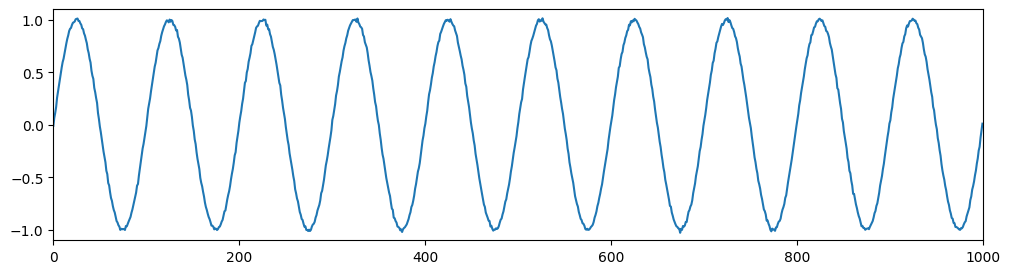

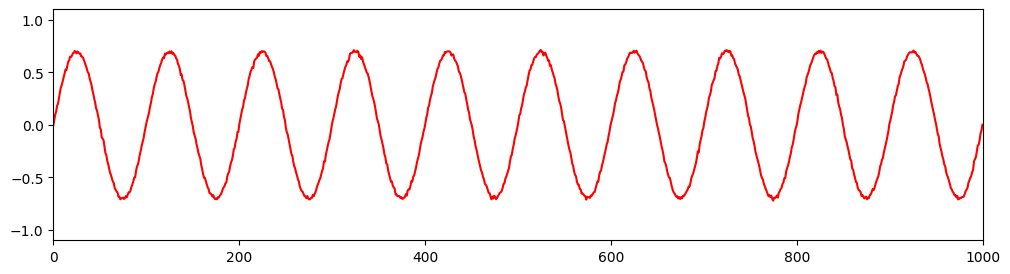

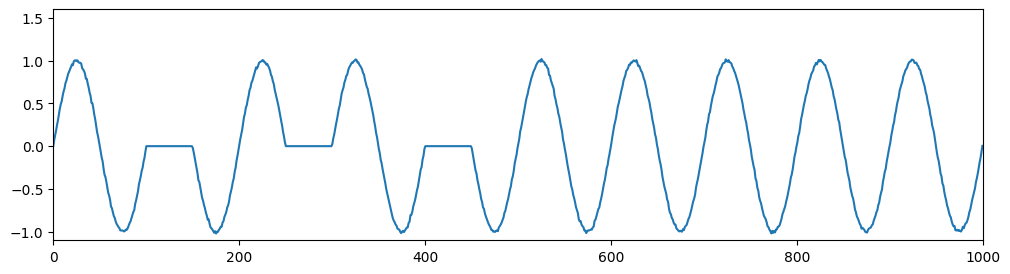

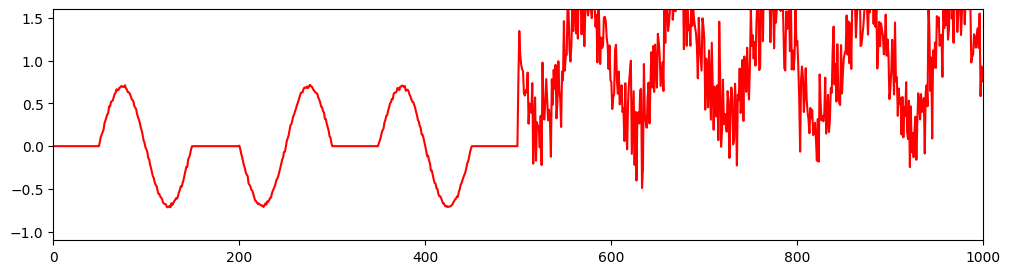

In [501]:
plt.figure(figsize=(12, 3)) 
plt.plot(sig1_sync)
plt.ylim(-1.1,1.1)
plt.xlim(0,1000)
plt.savefig(pathsave+'/'+'sine_sync1',bbox_inches='tight')

plt.show()

plt.figure(figsize=(12, 3))
plt.plot(sig2_sync, color='r')
plt.ylim(-1.1,1.1)
plt.xlim(0,1000)
plt.savefig(pathsave+'/'+'sine_sync2',bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 3)) 
plt.plot(sig1_async)
plt.ylim(-1.1,1.6)
plt.xlim(0,1000)
plt.savefig(pathsave+'/'+'sine_async1',bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(sig2_async, color='r')
plt.ylim(-1.1,1.6)
plt.xlim(0,1000)
plt.savefig(pathsave+'/'+'sine_async2',bbox_inches='tight')
plt.show()

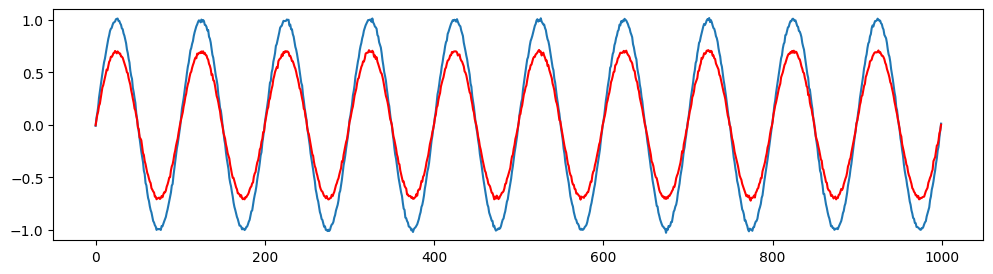

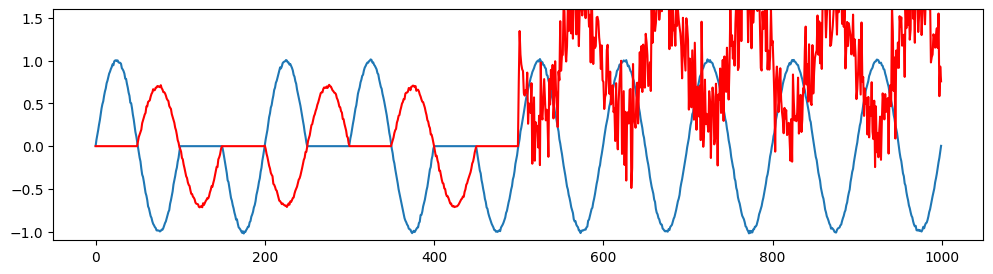

In [502]:
plt.figure(figsize=(12, 3)) 
plt.plot(sig1_sync)
plt.plot(sig2_sync, color='r')
plt.ylim(-1.1,1.1)
plt.savefig(pathsave+'/'+'sine_sync',bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 3)) 
plt.plot(sig1_async)
plt.plot(sig2_async, color='r')
plt.ylim(-1.1,1.6)
plt.savefig(pathsave+'/'+'sine_async',bbox_inches='tight')
plt.show()

In [503]:
def dtw_calculate(p_pitch,c_pitch): # calculate the dtw distance
    # Define a simple distance function for scalar values
    distance_func = lambda a, b: abs(a - b)
    # Compute the fastDTW distance and optimal alignment path using the normalized data
    distance, path = fastdtw(p_pitch, c_pitch, dist=distance_func)
    print("FastDTW distance ", distance)
    print("FastDTW distance (normalized)/duration:", distance/(len(p_pitch)))
    return distance, path

In [504]:
distance_td_f0mean,path_td_f0mean=dtw_calculate(sig1_sync,sig2_sync)
distance_asd_f0mean,path_asd_f0mean=dtw_calculate(sig1_async,sig2_async)

FastDTW distance  110.39136548214314
FastDTW distance (normalized)/duration: 0.11039136548214315
FastDTW distance  524.978738209336
FastDTW distance (normalized)/duration: 0.524978738209336


In [505]:
def path_plot(pathin,p_pitch,c_pitch,namein,distancein): #plot the path of the DTW matching
    path=np.array(pathin)
    pause_mask_parent = np.isnan(p_pitch)
    #print(len(np.where(pause_mask_parent==True)[0]))
    pause_mask_child  = np.isnan(c_pitch)
    parent_pauses_on_path = pause_mask_parent[path[:, 0]]
    child_pauses_on_path  = pause_mask_child[path[:, 1]]
    #print(len(np.where(parent_pauses_on_path==True)[0]))
    pause_on_path = parent_pauses_on_path | child_pauses_on_path
    # Now plot the warping path with a diagonal line for reference.
        
    i_indices = path[:, 0]
    j_indices = path[:, 1]
    lags = j_indices - i_indices  # Positive: mother leads, Negative: child leads

    total = len(lags)
    n_mother_leads = np.sum(lags > 0)
    n_child_leads = np.sum(lags < 0)
    n_sync = np.sum(lags == 0)

    prop_mother_leads = n_mother_leads / total
    prop_child_leads = n_child_leads / total
    prop_sync = n_sync / total
    avg_lag = np.mean(lags)
    std_lag = np.std(lags)

    stats = {
        'prop_mother_leads': prop_mother_leads,
        'prop_child_leads': prop_child_leads,
        'prop_synchronous': prop_sync,
        'average_lag': avg_lag,
        'lag_std': std_lag
    }

    print("DTW Leading Role Stats:")
    for k, v in stats.items():
        print(f"{k}: {v:.3f}")

    plt.figure(figsize=(6, 6))
    plt.plot(path[:, 0], path[:, 1],  linestyle='-', label='Alignment Path')

    # Overlay markers where pauses occurred (blue 'x' markers)
    #plt.scatter(path[pause_on_path, 0], path[pause_on_path, 1],
            #color='orange', marker='x', s=5, label='Pauses (filled)')

    # Plot the diagonal line
    max_val = max(path[:, 0].max(), path[:, 1].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Diagonal')

    plt.xlabel("Signal1")
    plt.ylabel("Signal2")
    plt.title("FastDTW Optimal Alignment Path_"+namein+'_'+str(np.round(distancein,decimals=2)))
    plt.savefig(pathsave+'/'+'dtw'+namein,bbox_inches='tight')
    plt.show()

DTW Leading Role Stats:
prop_mother_leads: 0.465
prop_child_leads: 0.471
prop_synchronous: 0.065
average_lag: -0.030
lag_std: 5.837


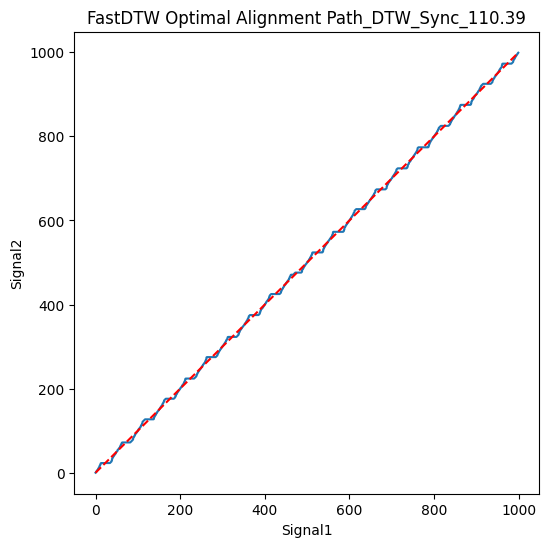

DTW Leading Role Stats:
prop_mother_leads: 0.000
prop_child_leads: 0.931
prop_synchronous: 0.069
average_lag: -187.618
lag_std: 88.295


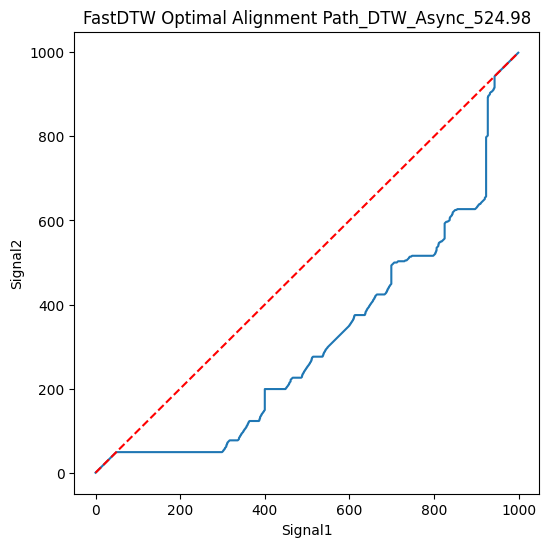

In [506]:
path_plot(path_td_f0mean,sig1_sync,sig2_sync,'DTW_Sync',distance_td_f0mean)
path_plot(path_asd_f0mean,sig1_async,sig2_async,'DTW_Async',distance_asd_f0mean)

In [507]:
def plot_dtw_matching(series1, series2,pathin, offset=4): # plot the dtw matching. This is not for the analysis but only for visualization to confirm whether the matching is as expected
    
    # Create x-axis indices (assumes both series have the same length)
    n = len(series1)
    x = np.arange(n)
    
    # Prepare the plot: plot series1 (shifted upward) and series2
    plt.figure(figsize=(12, 8))
    plt.plot(x, series1 + offset, label="Signal1", color="blue")
    plt.plot(x, series2, label="Signal2", color="red")
    
    # For each matching pair in the warping path, draw a connecting line
    # Each pair (i, j) means that point i in series1 is matched with point j in series2.
    for i, j in pathin:
        plt.plot([i, j], [series1[i] + offset, series2[j]], color='gray', linewidth=0.5)
    
    plt.xlabel("Time index")
    plt.ylabel("Standardized Pitch")
    plt.title("DTW Matching between Two Time Series")
    #plt.legend()
    plt.savefig(pathsave+'/'+'dtw', bbox_inches='tight')
    
    plt.show()


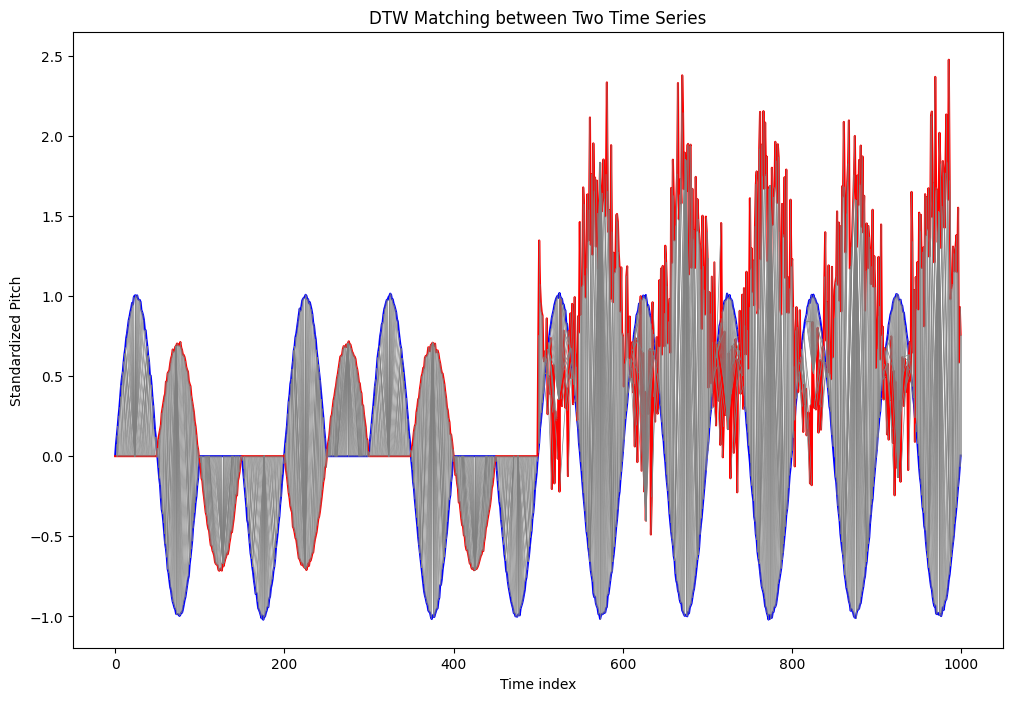

In [508]:
plot_dtw_matching(sig1_async,sig2_async, np.array(path_td_f0mean), offset=0)

In [509]:
def corr_nan_safe(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    #print(np.sum(mask))
    if np.sum(mask) < 5:
        return 0
    return np.corrcoef(x[mask], y[mask])[0, 1]
def rolling_tlcc(series1, series2, window_size, max_lag): # rolling window cross-correlation
    correlations = []
    lags = range(-max_lag, max_lag + 1)
    series1_n=series1.copy()
    series2_n=series2.copy()
    series1_n[np.where(np.abs(series1 <0.0001))[0]] = np.nan
    series2_n[np.where(np.abs(series2 <0.0001))[0]] = np.nan   
    for i in range(len(series1) - window_size + 1):
        window1 = series1_n[i:i + window_size]
        window2 = series2_n[i:i + window_size]
        
        # Compute cross-correlation for different lags
        cross_corr = []
        for lag in lags:
            if lag > 0:
                #corr = np.corrcoef(window1[:-lag], window2[lag:])[0, 1] if len(window1[:-lag]) > 1 else np.nan
                corr = corr_nan_safe(window1[:-lag], window2[lag:])
            elif lag < 0:
                #corr = np.corrcoef(window1[-lag:], window2[:lag])[0, 1] if len(window1[-lag:]) > 1 else np.nan
                corr = corr_nan_safe(window1[-lag:], window2[:lag])
            else:
                #corr = np.corrcoef(window1, window2)[0, 1]
                corr = corr_nan_safe(window1, window2)
            cross_corr.append(corr)
        
        correlations.append(cross_corr)
    
    return pd.DataFrame(correlations, columns=lags)

In [516]:
tlcc_results_td_mean=rolling_tlcc(sig1_sync,sig2_sync, 100, 50)
tlcc_results_asd_mean=rolling_tlcc(sig1_async,sig2_async, 100, 50)

In [517]:
def summarize_tlcc(tlcc_df,namein):
    peak_lags = tlcc_df.idxmax(axis=1)
    max_corrs = tlcc_df.max(axis=1)

    stats = {
        "prop_mother_leads": np.mean(peak_lags > 0),
        "prop_child_leads": np.mean(peak_lags < 0),
        "prop_synchronous": np.mean(peak_lags == 0),
        "avg_peak_lag": peak_lags.mean(),
        "std_peak_lag": peak_lags.std(),
        "avg_max_corr": max_corrs.mean(),
        "std_max_corr": max_corrs.std()
    }

    print("Rolling TLCC Summary:")
    for k, v in stats.items():
        print(f"{k}: {v:.3f}")
    plt.figure(figsize=(6, 4))
    plt.hist(peak_lags, bins=np.arange(tlcc_df.columns.min(), tlcc_df.columns.max()+1), color='skyblue', edgecolor='k')
    plt.axvline(0, color='red', linestyle='--', label='Synchronous')
    plt.xlabel("Lag (time steps)")
    plt.ylabel("Number of Windows")
    plt.title("Distribution of Peak Lags")
    plt.legend()
    plt.tight_layout()
    plt.savefig(pathsave+'/'+namein,bbox_inches='tight')
    plt.show()
    return stats, peak_lags, max_corrs

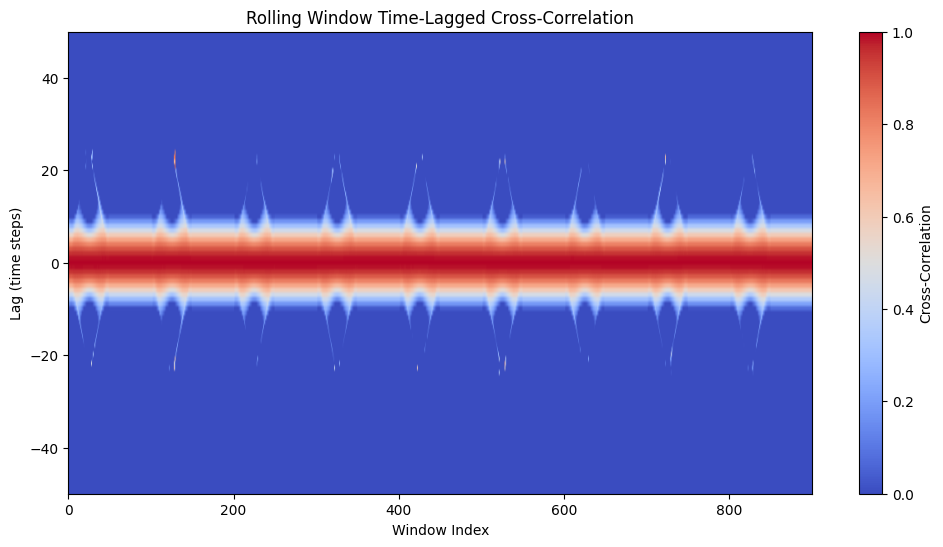

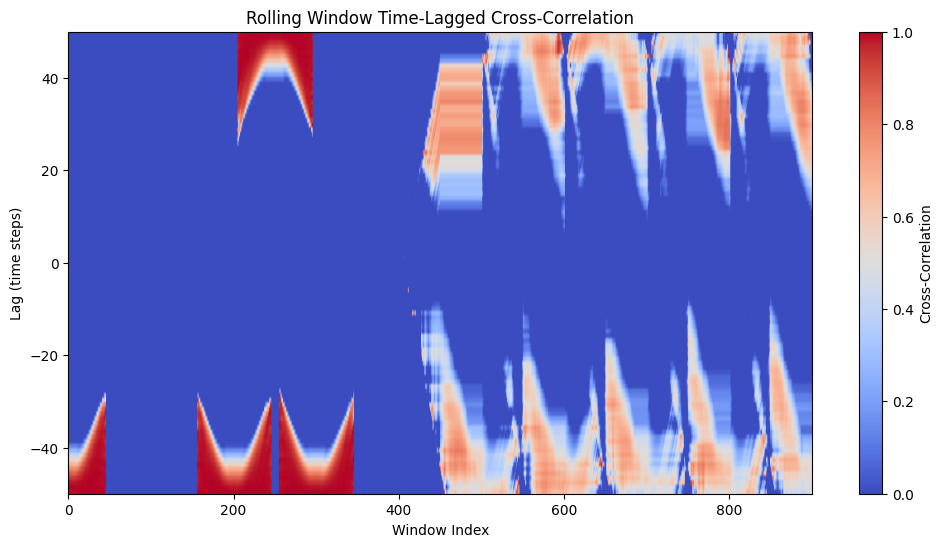

In [518]:
plt.figure(figsize=(12, 6)) #plot the cross-correlation results
plt.imshow(tlcc_results_td_mean.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results_td_mean), -50, 50],vmin=0,vmax=1)
plt.colorbar(label="Cross-Correlation")
plt.xlabel("Window Index")
plt.ylabel("Lag (time steps)")
plt.title("Rolling Window Time-Lagged Cross-Correlation")
plt.savefig(pathsave+'/'+'tlcc_sync',bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(tlcc_results_asd_mean.T, aspect='auto', cmap='coolwarm', extent=[0, len(tlcc_results_asd_mean), -50, 50],vmin=0,vmax=1)
plt.colorbar(label="Cross-Correlation")
plt.xlabel("Window Index")
plt.ylabel("Lag (time steps)")
plt.title("Rolling Window Time-Lagged Cross-Correlation")
plt.savefig(pathsave+'/'+'tlcc_async',bbox_inches='tight')
plt.show()

Rolling TLCC Summary:
prop_mother_leads: 0.000
prop_child_leads: 0.000
prop_synchronous: 1.000
avg_peak_lag: 0.000
std_peak_lag: 0.000
avg_max_corr: 0.998
std_max_corr: 0.000


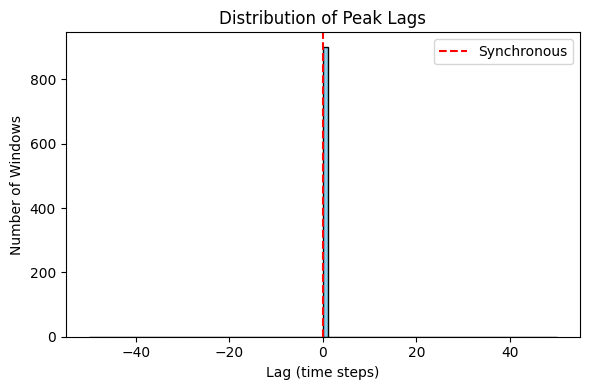

Rolling TLCC Summary:
prop_mother_leads: 0.434
prop_child_leads: 0.566
prop_synchronous: 0.000
avg_peak_lag: -6.018
std_peak_lag: 44.819
avg_max_corr: 0.651
std_max_corr: 0.356


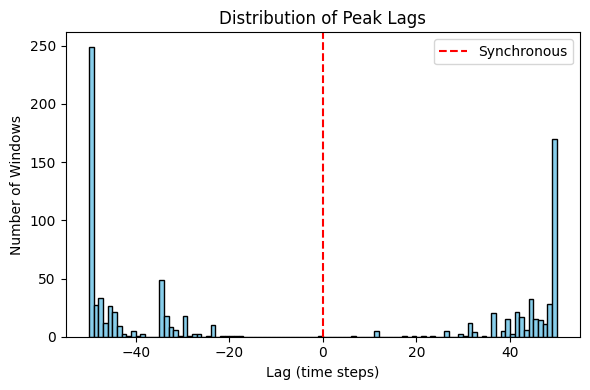

In [519]:
stats_td_mean, peak_lags_td_mean, max_corrs_td_mean = summarize_tlcc(tlcc_results_td_mean,'tlcc_sum_sync')
stats_asd_mean, peak_lags_asd_mean, max_corrs_asd_mean = summarize_tlcc(tlcc_results_asd_mean,'tlcc_sum_async')

In [428]:
def normalize_with_mask(series):
    """Normalize a time series while ignoring NaN values."""
    valid_idx = ~np.isnan(series)  # Find non-NaN values
    series_norm = np.zeros_like(series) * np.nan  # Keep NaNs
    series_norm[valid_idx] = (series[valid_idx] - np.nanmin(series[valid_idx])) / (np.nanmax(series[valid_idx]) - np.nanmin(series[valid_idx]))
    return series_norm

def crp_analysis(series1, series2, threshold): #cross-recurrence plot
    N = len(series1)
    crp_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if np.isnan(series1[i]) or np.isnan(series2[j]):
                crp_matrix[i, j] = np.nan  # Ignore NaN values
            else:
                distance = np.abs(series1[i]-series2[j])
                crp_matrix[i, j] = 1 if distance < threshold else 0

    return crp_matrix

In [429]:
from collections import Counter

def extract_diagonal_lines(crp_matrix, min_length=2):
    """Extract diagonal line lengths (excluding the main diagonal)"""
    N = crp_matrix.shape[0]
    diagonals = []
    for k in range(-N + 1, N):
        diag = np.diagonal(crp_matrix, offset=k)
        if len(diag) < min_length:
            continue
        count = 0
        for val in diag:
            if val == 1:
                count += 1
            else:
                if count >= min_length:
                    diagonals.append(count)
                count = 0
        if count >= min_length:
            diagonals.append(count)
    return diagonals

def extract_vertical_lines(crp_matrix, min_length=2):
    """Extract vertical line lengths"""
    N = crp_matrix.shape[0]
    verticals = []
    for col in range(N):
        count = 0
        for row in range(N):
            val = crp_matrix[row, col]
            if val == 1:
                count += 1
            else:
                if count >= min_length:
                    verticals.append(count)
                count = 0
        if count >= min_length:
            verticals.append(count)
    return verticals

def crqa_metrics(crp_matrix, min_length=2):
    valid_mask = ~np.isnan(crp_matrix)
    crp_valid = crp_matrix[valid_mask]

    RR = np.nansum(crp_matrix) / np.size(crp_matrix)  # Recurrence Rate

    diagonals = extract_diagonal_lines(crp_matrix, min_length)
    verticals = extract_vertical_lines(crp_matrix, min_length)

    # Determinism: proportion of recurrence points forming diagonal lines
    total_diag_points = np.sum(diagonals)
    total_rec_points = np.nansum(crp_matrix)
    DET = total_diag_points / total_rec_points if total_rec_points > 0 else 0

    # Longest Diagonal Line
    Lmax = max(diagonals) if diagonals else 0

    # Entropy (Shannon) of diagonal line lengths
    if diagonals:
        diag_counts = Counter(diagonals)
        diag_probs = np.array(list(diag_counts.values())) / sum(diag_counts.values())
        ENTR = -np.sum(diag_probs * np.log2(diag_probs))
    else:
        ENTR = 0

    # Laminarity: proportion of vertical recurrence points forming vertical lines
    total_vert_points = np.sum(verticals)
    LAM = total_vert_points / total_rec_points if total_rec_points > 0 else 0

    # Trapping Time: average vertical line length
    TT = np.mean(verticals) if verticals else 0

    return {
        "RR": RR,
        "DET": DET,
        "Lmax": Lmax,
        "ENTR": ENTR,
        "LAM": LAM,
        "TT": TT
    }


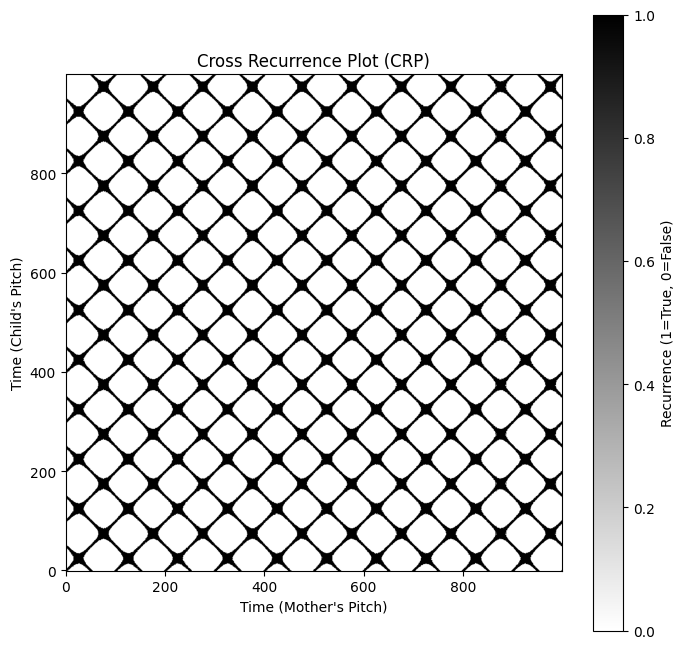

In [450]:
# Normalize time series
series1_norm = normalize_with_mask(sig1_sync)
series2_norm = normalize_with_mask(sig2_sync)

# Compute CRP with a chosen threshold
threshold = 0.1  # Adjust based on data range when the threshold is 1, it shows the CRP of vocal onset
crp_matrix_td = crp_analysis(series1_norm, series2_norm, threshold)

# Plot CRP
plt.figure(figsize=(8, 8))
plt.imshow(crp_matrix_td, cmap='binary', origin='lower')
plt.xlabel("Time (Mother's Pitch)")
plt.ylabel("Time (Child's Pitch)")
plt.title("Cross Recurrence Plot (CRP)")
plt.colorbar(label="Recurrence (1=True, 0=False)")
plt.savefig(pathsave+'/'+'crp_Sync',bbox_inches='tight')
plt.show()

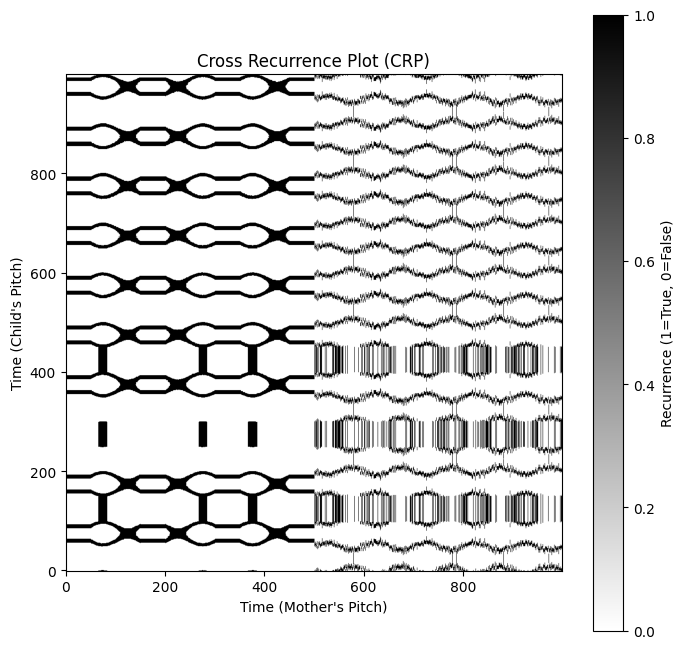

In [451]:
# Normalize time series
series1_norm = normalize_with_mask(sig1_async)
series2_norm = normalize_with_mask(sig2_async)

# Compute CRP with a chosen threshold
threshold = 0.1  # Adjust based on data range
crp_matrix_asd = crp_analysis(series1_norm, series2_norm, threshold)

# Plot CRP
plt.figure(figsize=(8, 8))
plt.imshow(crp_matrix_asd, cmap='binary', origin='lower')
plt.xlabel("Time (Mother's Pitch)")
plt.ylabel("Time (Child's Pitch)")
plt.title("Cross Recurrence Plot (CRP)")
plt.colorbar(label="Recurrence (1=True, 0=False)")
plt.savefig(pathsave+'/'+'crp_async',bbox_inches='tight')
plt.show()

In [432]:
metrics_td = crqa_metrics(crp_matrix_td)
metrics_asd = crqa_metrics(crp_matrix_asd)

In [433]:
for k, v in metrics_td.items():
    print('TD: ',f"{k}: {v:.3f}")
for k, v in metrics_asd.items():
    print(f"{k}: {v:.3f}")

TD:  RR: 0.193
TD:  DET: 0.994
TD:  Lmax: 1000.000
TD:  ENTR: 3.574
TD:  LAM: 0.999
TD:  TT: 11.956
RR: 0.171
DET: 0.846
Lmax: 35.000
ENTR: 3.102
LAM: 0.999
TT: 10.270


In [434]:
def compute_mutual_information(series1, series2, num_bins=5): #mutual information
    """
    Compute the mutual information between two time series.
    
    :param series1: First time series (e.g., mother's pitch).
    :param series2: Second time series (e.g., child's pitch).
    :param num_bins: Number of bins for discretization.
    :return: Mutual information score.
    """
    # Remove NaNs
    valid_idx = ~np.isnan(series1) & ~np.isnan(series2)
    series1, series2 = series1[valid_idx], series2[valid_idx]
    #print(len(series1))

    # Reshape for sklearn function
    series1 = series1.reshape(-1, 1)
    series2 = series2.reshape(-1, 1)

    # Compute Mutual Information
    if len(series1)>=6 and len(series2)>=6:
        mi_score = mutual_info_regression(series1, series2, discrete_features=False, n_neighbors=num_bins)
    else:
        mi_score=[0]
    
    return mi_score[0]  # MI value

In [435]:
def time_lagged_mutual_information(series1, series2, max_lag=10, num_bins=5): # time lag mutual information
    """
    Compute mutual information at different time lags.
    
    :param series1: First time series (e.g., mother's pitch).
    :param series2: Second time series (e.g., child's pitch).
    :param max_lag: Maximum lag to consider.
    :return: Array of mutual information values for each lag.
    """
    mi_scores = []
    lags = np.arange(-max_lag, max_lag + 1)

    for lag in lags:
        if lag > 0:
            mi = compute_mutual_information(series1[:-lag], series2[lag:], num_bins)
        elif lag < 0:
            mi = compute_mutual_information(series1[-lag:], series2[:lag], num_bins)
        else:
            mi = compute_mutual_information(series1, series2, num_bins)
        mi_scores.append(mi)

    return lags, np.array(mi_scores)


In [436]:
from scipy.signal import find_peaks

def summarize_tlmi(lags, mi_lagged, lag_step_ms=None, peak_prominence=0.01, plot=True):
    """
    Summarize and visualize time-lagged mutual information (TLMI), including top 3 peaks.

    Parameters:
    - lags: Array of lag values (e.g., in time steps)
    - mi_lagged: Mutual information values at each lag
    - lag_step_ms: Optional, time step in milliseconds (to convert lags to ms)
    - peak_prominence: Minimum prominence to count local peaks
    - plot: Whether to display the TLMI plot

    Returns:
    - stats: Dictionary of summary statistics including top 3 peaks
    """
    stats = {}

    # Basic stats
    stats['mean_mi'] = np.mean(mi_lagged)
    stats['std_mi'] = np.std(mi_lagged)

    # Find all peaks
    peaks, _ = find_peaks(mi_lagged, prominence=peak_prominence)
    peak_vals = mi_lagged[peaks]
    peak_lags = lags[peaks]

    # Sort by peak value (highest first)
    sorted_idx = np.argsort(peak_vals)[::-1]
    sorted_peaks = peak_vals[sorted_idx]
    sorted_lags = peak_lags[sorted_idx]

    # Extract top 3 peaks
    for i in range(min(3, len(sorted_peaks))):
        stats[f'peak_{i+1}_mi'] = sorted_peaks[i]
        stats[f'peak_{i+1}_lag'] = sorted_lags[i]
        if lag_step_ms:
            stats[f'peak_{i+1}_lag_ms'] = sorted_lags[i] * lag_step_ms
        stats[f'peak_{i+1}_leader'] = (
            "Mother leads" if sorted_lags[i] > 0 else
            "Child leads" if sorted_lags[i] < 0 else
            "Synchronous"
        )

    stats['n_local_peaks'] = len(peaks)

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(lags, mi_lagged, marker='o', label='MI')
        plt.axvline(0, color='red', linestyle='--', label='Lag = 0')
        if len(sorted_lags) > 0:
            plt.axvline(sorted_lags[0], color='green', linestyle='--', label=f'Peak 1 = {sorted_lags[0]}')
        if len(sorted_lags) > 1:
            plt.axvline(sorted_lags[1], color='blue', linestyle='--', label=f'Peak 2 = {sorted_lags[1]}')
        if len(sorted_lags) > 2:
            plt.axvline(sorted_lags[2], color='purple', linestyle='--', label=f'Peak 3 = {sorted_lags[2]}')
        plt.xlabel("Lag (time steps)" + (f" ({lag_step_ms} ms/step)" if lag_step_ms else ""))
        plt.ylabel("Mutual Information")
        plt.title("Time-Lagged Mutual Information (TLMI)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return stats

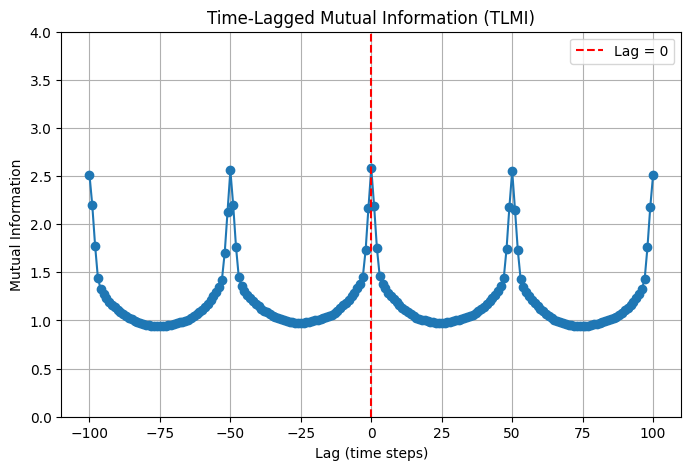

In [452]:

# Compute Time-Lagged Mutual Information

lags_p_td, mi_lagged_p_td = time_lagged_mutual_information(sig1_sync, sig2_sync, max_lag=100, num_bins=50)

# Plot Time-Lagged MI
plt.figure(figsize=(8, 5))
plt.plot(lags_p_td, mi_lagged_p_td, marker='o')
plt.ylim(-0,4)
plt.xlabel("Lag (time steps)")
plt.ylabel("Mutual Information")
plt.title("Time-Lagged Mutual Information (TLMI)")
plt.axvline(0, color='red', linestyle='--', label="Lag = 0")
plt.savefig(pathsave+'/'+'tlmi_Sync',bbox_inches='tight')
plt.legend()
plt.grid()
plt.show()


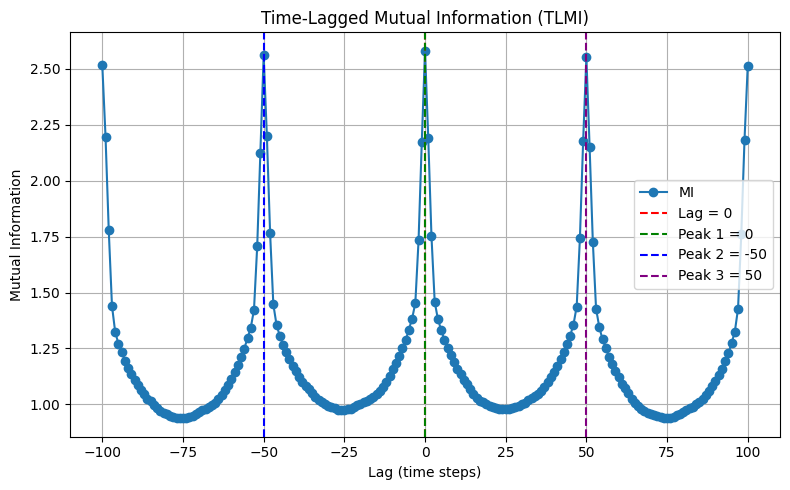

mean_mi: 1.203
std_mi: 0.348
peak_1_mi: 2.581
peak_1_lag: 0
peak_1_leader: Synchronous
peak_2_mi: 2.560
peak_2_lag: -50
peak_2_leader: Child leads
peak_3_mi: 2.552
peak_3_lag: 50
peak_3_leader: Mother leads
n_local_peaks: 3.000


In [438]:
stats_tlmi_p_td = summarize_tlmi(lags_p_td, mi_lagged_p_td)

for k, v in stats_tlmi_p_td.items():
    print(f"{k}: {v:.3f}" if isinstance(v, (int, float, np.floating)) else f"{k}: {v}")

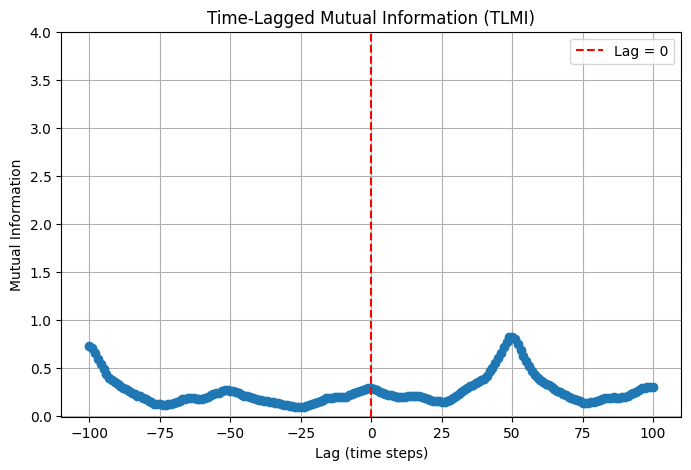

In [453]:
# Compute Time-Lagged Mutual Information

lags_p_asd, mi_lagged_p_asd = time_lagged_mutual_information(sig1_async, sig2_async, max_lag=100, num_bins=50)

# Plot Time-Lagged MI
plt.figure(figsize=(8, 5))
plt.plot(lags_p_asd, mi_lagged_p_asd, marker='o')
plt.ylim(-0.01,4)
plt.xlabel("Lag (time steps)")
plt.ylabel("Mutual Information")
plt.title("Time-Lagged Mutual Information (TLMI)")
plt.axvline(0, color='red', linestyle='--', label="Lag = 0")
plt.savefig(pathsave+'/'+'tlmi_async',bbox_inches='tight')
plt.legend()
plt.grid()
plt.show()

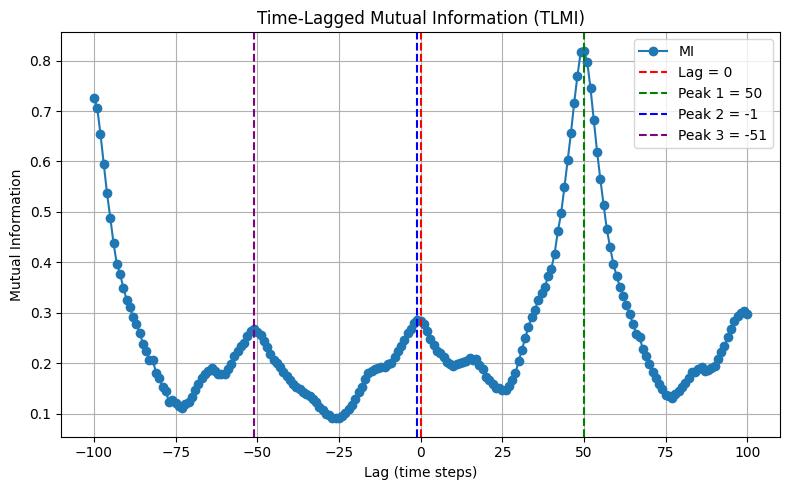

mean_mi: 0.257
std_mi: 0.154
peak_1_mi: 0.820
peak_1_lag: 50
peak_1_leader: Mother leads
peak_2_mi: 0.285
peak_2_lag: -1
peak_2_leader: Child leads
peak_3_mi: 0.267
peak_3_lag: -51
peak_3_leader: Child leads
n_local_peaks: 5.000


In [524]:
stats_tlmi_p_asd = summarize_tlmi(lags_p_asd, mi_lagged_p_asd)

for k, v in stats_tlmi_p_asd.items():
    print(f"{k}: {v:.3f}" if isinstance(v, (int, float, np.floating)) else f"{k}: {v}")

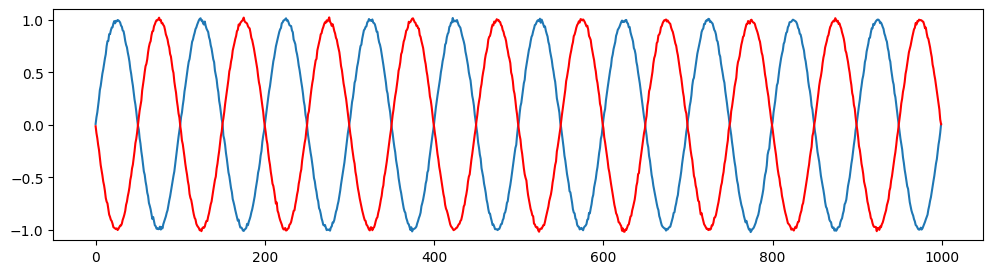

In [441]:
t = np.linspace(0, 10, 1000)
t_shifted = t + 0.5  # Time shift
# Base sine wave
sync_base = np.sin(2 * np.pi * 1.0 * t)
sync_base_s = np.sin(2 * np.pi * 1.0 * t_shifted)
# Add small noise to simulate natural variation
sig1_sync_s = sync_base + 0.01 * np.random.randn(len(t))
sig2_sync_s = sync_base_s + 0.01 * np.random.randn(len(t))

plt.figure(figsize=(12, 3)) 
plt.plot(sig1_sync_s)
plt.plot(sig2_sync_s, color='r')
plt.ylim(-1.1,1.1)
plt.savefig(pathsave+'/'+'sine_sync_s',bbox_inches='tight')
plt.show()

In [442]:
#!pip3 install pycwt

In [443]:
import pycwt as wavelet  # Import the wavelet package
from pycwt.helpers import find
from scipy.ndimage import gaussian_filter

In [444]:
def smooth_wavelet_power(power, scales, sigma=1):
    """
    Custom function to smooth wavelet power using Gaussian filtering.
    
    :param power: Wavelet power spectrum (2D array).
    :param scales: Array of scales.
    :param sigma: Standard deviation for Gaussian smoothing.
    :return: Smoothed power spectrum.
    """
    smoothed = np.copy(power)
    for i in range(len(scales)):
        smoothed[i, :] = gaussian_filter(power[i, :], sigma)
    return smoothed

def cross_wavelet_analysis(series1, series2, dt=1.0): # cross wavelet analysis
    """
    Perform Cross-Wavelet Transform (XWT) and Wavelet Coherence (WTC).

    :param series1: First time series (e.g., mother's pitch).
    :param series2: Second time series (e.g., child's pitch).
    :param dt: Sampling period (default=1).
    :return: Wavelet coherence and cross-wavelet results.
    """
    # Remove NaNs (wavelet transform does not support NaNs)
    valid_idx = ~np.isnan(series1) & ~np.isnan(series2)
    series1, series2 = series1[valid_idx], series2[valid_idx]

    # Define the mother wavelet (Morlet)
    mother = wavelet.Morlet(6)

    # Define the smallest scale and number of scales
    s0 = 2 * dt  # Smallest resolvable scale
    dj = 1 / 12  # Frequency scale spacing
    J = int(7 / dj)  # Number of scales

    # Compute Continuous Wavelet Transform (CWT) for both signals
    wave1, scales, freqs, coi, _, _ = wavelet.cwt(series1, dt, dj=dj, s0=s0, J=J, wavelet=mother)
    wave2, _, _, _, _, _ = wavelet.cwt(series2, dt, dj=dj, s0=s0, J=J, wavelet=mother)

    # Compute Cross-Wavelet Transform (XWT)
    xwt = wave1 * np.conj(wave2)

    # Compute Wavelet Coherence (WTC) using Gaussian Smoothing
    s_wave1 = smooth_wavelet_power(np.abs(wave1) ** 2, scales)
    s_wave2 = smooth_wavelet_power(np.abs(wave2) ** 2, scales)
    s_xwt = smooth_wavelet_power(np.abs(xwt) ** 2, scales)
    coherence = s_xwt / (s_wave1 * s_wave2)  # Normalize coherence

    return coherence, freqs, coi

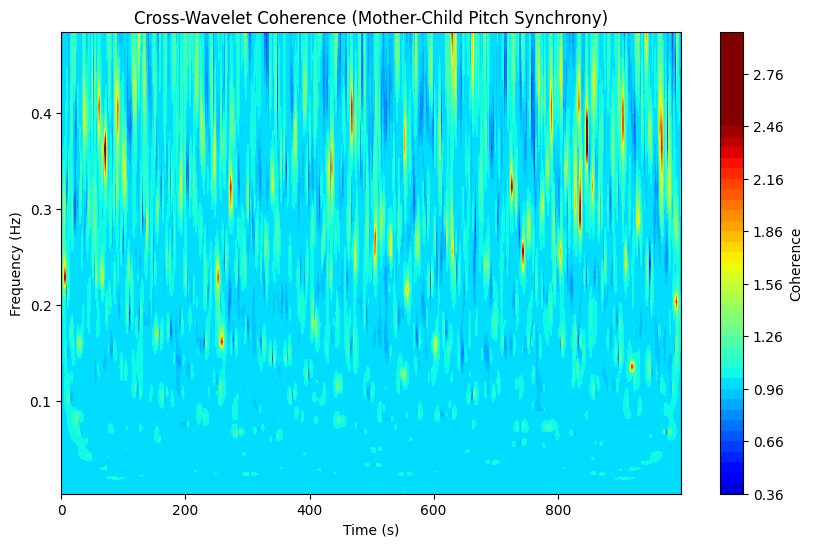

In [454]:
# Compute Cross-Wavelet Transform
coherence_p_td, freqs_p_td, coi_p_td = cross_wavelet_analysis(sig1_sync, sig2_sync, 1)
time_p_td=np.arange(len(sig1_sync))
# Plot Wavelet Coherence (Time-Frequency Synchrony)
plt.figure(figsize=(10, 6))
plt.contourf(time_p_td, freqs_p_td, coherence_p_td, cmap="jet", levels=50,vmin=0.2,vmax=2.5)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cross-Wavelet Coherence (Mother-Child Pitch Synchrony)")
plt.savefig(pathsave+'/'+'cwt_sync',bbox_inches='tight')
plt.colorbar(label="Coherence")
plt.show()

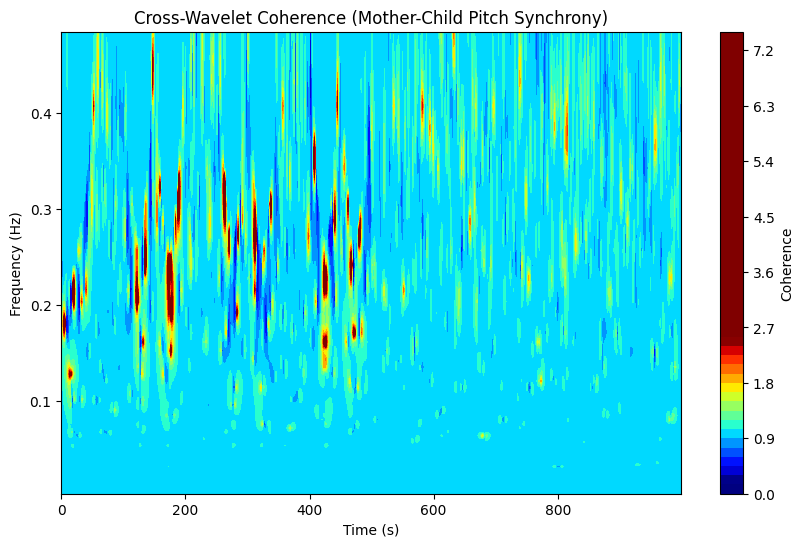

In [455]:
# Compute Cross-Wavelet Transform
coherence_p_asd, freqs_p_asd, coi_p_asd = cross_wavelet_analysis(sig1_async, sig2_async, dt=1)
time_p_asd=np.arange(len(sig1_async))
# Plot Wavelet Coherence (Time-Frequency Synchrony)
plt.figure(figsize=(10, 6))
plt.contourf(time_p_asd, freqs_p_asd, coherence_p_asd, cmap="jet", levels=50,vmin=0.2,vmax=2.5)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Cross-Wavelet Coherence (Mother-Child Pitch Synchrony)")
plt.savefig(pathsave+'/'+'cwt_Async',bbox_inches='tight')
plt.colorbar(label="Coherence")
plt.show()

In [522]:
def analyze_wavelet_coherence(coherence, freqs, time, band1=(0.1, 0.3), band2=(0.3, 0.5), threshold=1, plot=True):
    """
    Analyze cross-wavelet coherence results statistically.

    Parameters:
    - coherence: 2D array (freqs x timepoints), the coherence matrix
    - freqs: 1D array, frequencies corresponding to rows of coherence
    - time: 1D array, timepoints corresponding to columns of coherence
    - band: tuple, frequency range of interest (e.g., (0.1, 0.3) Hz)
    - threshold: float, coherence threshold for high synchrony detection
    - plot: bool, whether to produce summary plots

    Returns:
    - stats: dict containing summary statistics
    """
    stats = {}

    # 1. Global average coherence
    stats['mean_coherence'] = np.nanmean(coherence)

    # 2. Average coherence by frequency
    avg_by_freq = np.nanmean(coherence, axis=1)
    peak_freq = freqs[np.nanargmax(avg_by_freq)]
    stats['peak_coherence_freq'] = peak_freq
    stats['mean_coherence_by_freq'] = avg_by_freq

    # 3. Average coherence by time
    avg_by_time = np.nanmean(coherence, axis=0)
    stats['mean_coherence_by_time'] = avg_by_time

    # 4. Band-limited coherence
    band_mask1 = (freqs >= band1[0]) & (freqs <= band1[1])
    band_coherence1 = coherence[band_mask1, :]
    stats['sum_band_coherence_l'] = np.nansum(band_coherence1)
    band_mask2 = (freqs >= band2[0]) & (freqs <= band2[1])
    band_coherence2 = coherence[band_mask2, :]
    stats['sum_band_coherence_h'] = np.nansum(band_coherence2)
    
    # 5. High synchrony detection
    high_sync_mask = coherence > threshold
    stats['prop_coherence_above_threshold'] = np.sum(high_sync_mask) / coherence.size

    # 6. Optional plots
    if plot:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(freqs, avg_by_freq)
        plt.axvline(peak_freq, color='red', linestyle='--', label=f'Peak = {peak_freq:.2f} Hz')
        plt.ylim(0.96,1.1)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Mean Coherence")
        plt.title("Mean Coherence by Frequency")
        plt.grid(True)
        plt.legend()
        plt.savefig(pathsave+'/'+'sine_async_cwaq',bbox_inches='tight')

        plt.subplot(1, 2, 2)
        plt.plot(time, avg_by_time)
        plt.ylim(0.96,1.1)
        plt.xlabel("Time (s)")
        plt.ylabel("Mean Coherence")
        plt.title("Coherence Over Time")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Optional mask plot
        plt.figure(figsize=(10, 5))
        plt.contourf(time, freqs, high_sync_mask, cmap="Greys", levels=1)
        plt.colorbar()
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title(f"High Synchrony Mask (Coherence > {threshold})")
        plt.tight_layout()
        plt.show()

    return stats

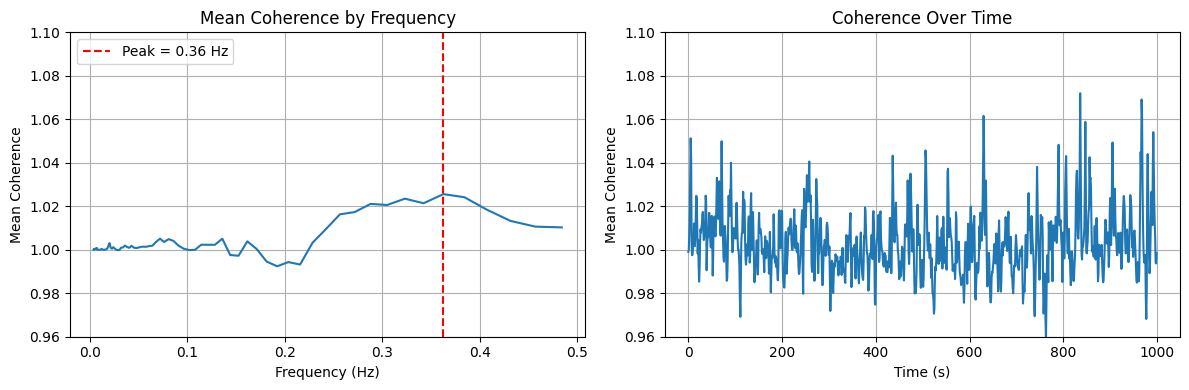

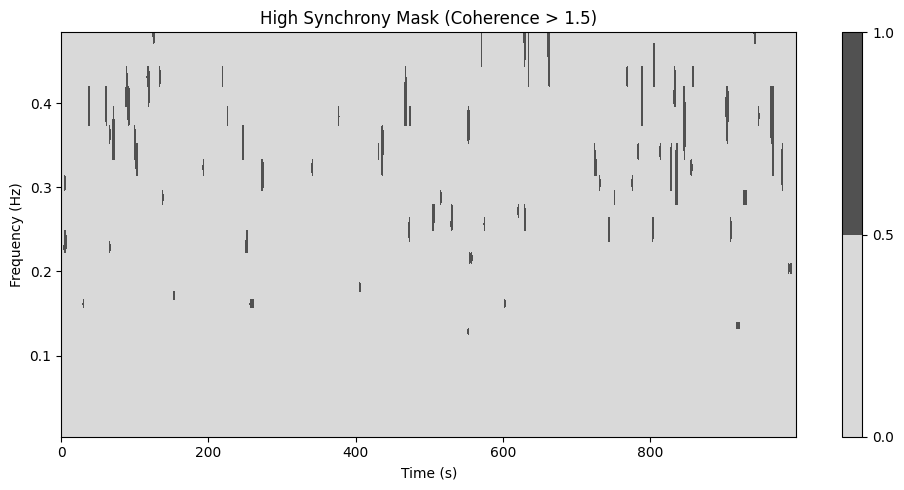

mean_coherence: 1.003
peak_coherence_freq: 0.363
sum_band_coherence_l: 19052.711
sum_band_coherence_h: 9167.883
prop_coherence_above_threshold: 0.003


In [521]:
stats_p_td = analyze_wavelet_coherence(coherence_p_td, freqs_p_td, time_p_td,
                                  band1=(0.1, 0.3), band2=(0.3, 0.5), threshold=1.5, plot=True)

# View summary stats
for k, v in stats_p_td.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.3f}")

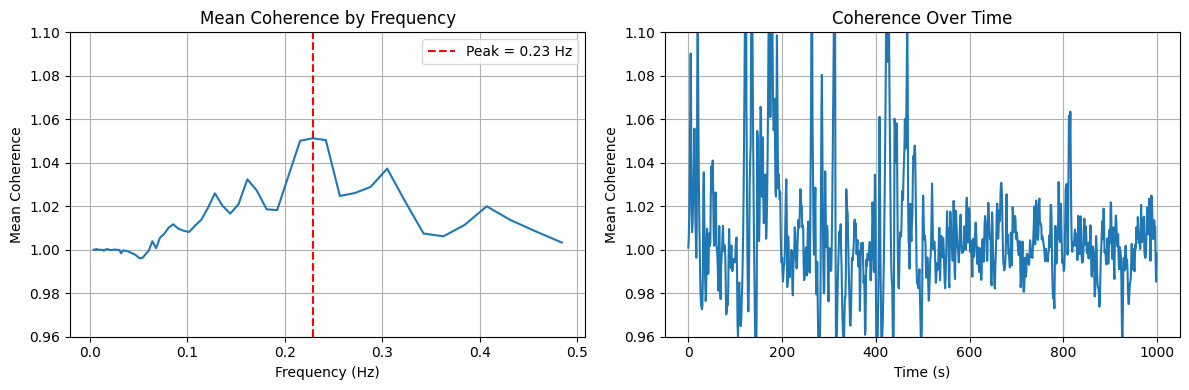

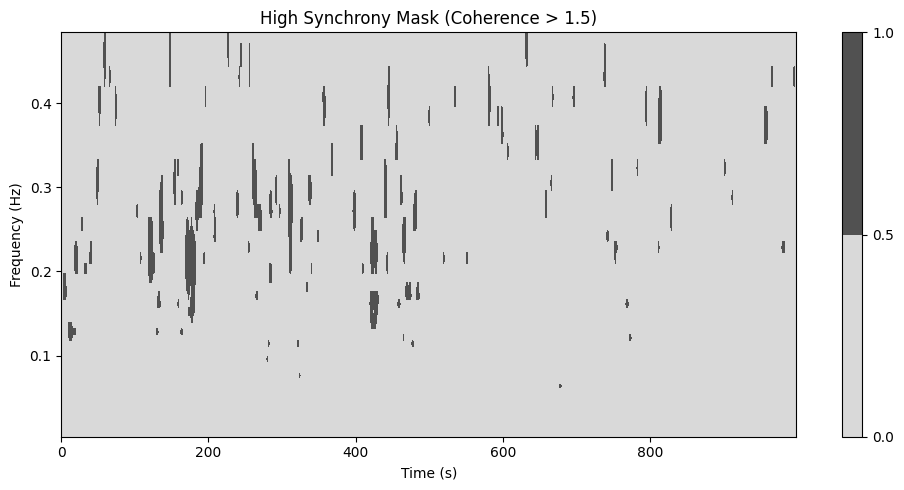

mean_coherence: 1.008
peak_coherence_freq: 0.228
sum_band_coherence_l: 19497.862
sum_band_coherence_h: 9130.298
prop_coherence_above_threshold: 0.008


In [523]:
stats_p_asd = analyze_wavelet_coherence(coherence_p_asd, freqs_p_asd, time_p_asd,
                                  band1=(0.1, 0.3), band2=(0.3, 0.5), threshold=1.5, plot=True)

# View summary stats
for k, v in stats_p_asd.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.3f}")